# Import Library

Impor library yang diperlukan

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


# Data Loading & Persiapan Awal

Menggabungkan file CSV

In [5]:
file_paths = [
    'umkm_dataset/data_transaksi_umkm_2022.csv',
    'umkm_dataset/data_transaksi_umkm_2023.csv',
    'umkm_dataset/data_transaksi_umkm_2024.csv',
    'umkm_dataset/data_transaksi_umkm_2025.csv',
    'umkm_dataset/data_transaksi_umkm_nasi_padang.csv'
]

In [6]:
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

Cek struktur dasar DataFrame

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78730 entries, 0 to 78729
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tanggal    78730 non-null  object
 1   jenis      78730 non-null  object
 2   nama       78730 non-null  object
 3   kategori   78730 non-null  object
 4   nominal    78730 non-null  int64 
 5   Nama Toko  33278 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB


In [8]:
df.head()

,tanggal,jenis,nama,kategori,nominal,Nama Toko
0,2022-01-01,pemasukan,Penjualan Mie Ayam,penjualan,90000,NaN
1,2022-01-01,pemasukan,Penjualan Pecel Lele,penjualan,78000,NaN
2,2022-01-01,pemasukan,Penjualan Bakso,penjualan,22000,NaN
3,2022-01-01,pemasukan,Penjualan Ayam Bakar,penjualan,150000,NaN
4,2022-01-01,pemasukan,Penjualan Jus Alpukat,penjualan,78000,NaN


# Data Preprocessing & Ekstraksi Fitur Harian

 Mengolah semua transaksi lalu menghasilkan DataFrame “daily” yang berisi ringkasan (aggregate) setiap hari per toko

Standarisasi nama kolom

In [9]:
df.columns = df.columns.str.lower()

Konversi tanggal menjadi tipe datetime

In [10]:
df['tanggal'] = pd.to_datetime(df['tanggal'])

Memisahkan nominal menjadi kolom “pemasukan” dan “pengeluaran”

In [11]:
df['pengeluaran'] = df.apply(lambda row: row['nominal'] if row['jenis'] == 'pengeluaran' else 0, axis=1)
df['pemasukan'] = df.apply(lambda row: row['nominal'] if row['jenis'] == 'pemasukan' else 0, axis=1)

Tambah kolom 'periode_minggu' (akhir periode Senin)

In [12]:
df['periode_minggu'] = df['tanggal'].dt.to_period('W-MON').apply(lambda r: r.start_time)

Agregasi per minggu

In [13]:
weekly = (
    df
    .groupby(['nama toko', 'periode_minggu'])
    .agg({
        'pemasukan':   'sum',
        'pengeluaran': 'sum',
        'nominal':     'count'   # ini akan jadi jumlah_transaksi
    })
    .rename(columns={'nominal': 'jumlah_transaksi'})
    .reset_index()
)

Tambahkan kolom 'laba_bersih' & 'rasio_keuangan'

In [14]:
weekly['laba_bersih'] = weekly['pemasukan'] - weekly['pengeluaran']
weekly['rasio_keuangan'] = weekly['pemasukan'] / (weekly['pengeluaran'] + 1)

hitung jumlah hari rugi perminggu

In [15]:
harian = (
    df
    .groupby(['nama toko', 'tanggal'])
    .agg({'pemasukan': 'sum', 'pengeluaran': 'sum'})
    .reset_index()
)
harian['flag_rugi'] = (harian['pengeluaran'] > harian['pemasukan']).astype(int)
harian['periode_minggu'] = harian['tanggal'].dt.to_period('W-MON').apply(lambda r: r.start_time)

hari_rugi_per_minggu = (
    harian
    .groupby(['nama toko', 'periode_minggu'])['flag_rugi']
    .sum()
    .reset_index(name='jumlah_hari_rugi')
)

Merge jumlah_hari_rugi ke weekly

In [16]:
weekly = weekly.merge(
    hari_rugi_per_minggu,
    on=['nama toko', 'periode_minggu'],
    how='left'
)


In [17]:
weekly['jumlah_hari_rugi'] = weekly['jumlah_hari_rugi'].fillna(0).astype(int)

In [18]:
weekly.head()

,nama toko,periode_minggu,pemasukan,pengeluaran,jumlah_transaksi,laba_bersih,rasio_keuangan,jumlah_hari_rugi
0,RM Sinar Balatas,2021-12-28,5818000,14545701,99,-8727701,0.399981,2
1,RM Sinar Balatas,2022-01-04,12660000,13309240,206,-649240,0.951219,2
2,RM Sinar Balatas,2022-01-11,12046000,13070540,197,-1024540,0.921614,1
3,RM Sinar Balatas,2022-01-18,11948000,12144892,188,-196892,0.983788,2
4,RM Sinar Balatas,2022-01-25,12354000,12621995,195,-267995,0.978768,2


Menentukan Label Multi‐Kelas

In [19]:
def kategori_laba(row):
    rasio = row['rasio_keuangan']
    if rasio >= 1.2:
        return 'Sehat'
    elif rasio >= 1.0:
        return 'Cukup Sehat'
    elif rasio >= 0.8:
        return 'Perlu Perhatian'
    else:
        return 'Perlu Penanganan Khusus'

weekly['label_kelas'] = weekly.apply(kategori_laba, axis=1)

# Tampilkan distribusi label
print(weekly['label_kelas'].value_counts())


label_kelas
Perlu Perhatian            63
Cukup Sehat                56
Perlu Penanganan Khusus    43
Sehat                      13
Name: count, dtype: int64


In [20]:
weekly.head()

,nama toko,periode_minggu,pemasukan,pengeluaran,jumlah_transaksi,laba_bersih,rasio_keuangan,jumlah_hari_rugi,label_kelas
0,RM Sinar Balatas,2021-12-28,5818000,14545701,99,-8727701,0.399981,2,Perlu Penanganan Khusus
1,RM Sinar Balatas,2022-01-04,12660000,13309240,206,-649240,0.951219,2,Perlu Perhatian
2,RM Sinar Balatas,2022-01-11,12046000,13070540,197,-1024540,0.921614,1,Perlu Perhatian
3,RM Sinar Balatas,2022-01-18,11948000,12144892,188,-196892,0.983788,2,Perlu Perhatian
4,RM Sinar Balatas,2022-01-25,12354000,12621995,195,-267995,0.978768,2,Perlu Perhatian


# Data Preparation

Persiapan Data untuk Model



Membuat fitur turunan

Untuk `rasio_transaksi`
> *"Rasio ini saya gunakan untuk mengukur efisiensi aktivitas transaksi terhadap pengeluaran. Semakin tinggi nilainya, berarti setiap unit pengeluaran menghasilkan lebih banyak transaksi. Penambahan +1 pada penyebut bertujuan untuk menghindari pembagian dengan nol ketika tidak ada pengeluaran. Konsep dasarnya mirip dengan rasio efisiensi dalam analisis keuangan, meskipun ini disesuaikan untuk konteks data mingguan."*

Untuk `persen_pengeluaran`
> *"Rasio ini menunjukkan seberapa besar proporsi pengeluaran dibanding total arus kas (pemasukan + pengeluaran). Ini berguna untuk memahami dominasi belanja terhadap keseluruhan aktivitas keuangan. Nilai kecil 1e-9 ditambahkan untuk mencegah error pembagian nol. Ini mirip dengan pendekatan proporsi dalam laporan keuangan atau rasio cost-to-income di sektor keuangan."*

Rumus ini bukan dari literatur tunggal, tapi merupakan bentuk praktik umum dalam data analysis — konsepnya terinspirasi dari rasio efisiensi dan rasio aktivitas keuangan. [Financial Analysis Ratio](https://www.jurnal.id/id/blog/rumus-rasio-keuangan-untuk-analisis-rasio-keuangan-perusahaan/?utm_source=chatgpt.com)

In [21]:
# Buat fitur turunan:
weekly['rasio_transaksi'] = weekly['jumlah_transaksi'] / (weekly['pengeluaran'] + 1)
weekly['persen_pengeluaran'] = weekly['pengeluaran'] / (weekly['pemasukan'] + weekly['pengeluaran'] + 1e-9)

# Pilih fitur yang TIDAK memuat pemasukan/pengeluaran secara mentah
features = [
    'pemasukan',
    'pengeluaran',
    'jumlah_transaksi',
    'jumlah_hari_rugi',
    'rasio_transaksi',
    'persen_pengeluaran'
]

In [22]:
X = weekly[features]
y = weekly['label_kelas']

Encode Label Menjadi Numerik

In [23]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Mapping label:", dict(zip(le.classes_, le.transform(le.classes_))))

# One-hot encoding untuk klasifikasi multi-kelas
y_cat = to_categorical(y_enc)

Mapping label: {'Cukup Sehat': np.int64(0), 'Perlu Penanganan Khusus': np.int64(1), 'Perlu Perhatian': np.int64(2), 'Sehat': np.int64(3)}


Normalisasi

In [24]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Split data menjadi training & testing

In [25]:
X_train, X_test, y_train_cat, y_test_cat, y_train_enc, y_test_enc = train_test_split(
    X_scaled, y_cat, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


pembuatan Model

In [26]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')  # 4 kelas output
])

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Pelatihan Model

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [29]:
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2111 - loss: 1.4081 - val_accuracy: 0.2857 - val_loss: 1.3905
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3467 - loss: 1.3819 - val_accuracy: 0.3571 - val_loss: 1.3389
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3375 - loss: 1.3476 - val_accuracy: 0.3571 - val_loss: 1.3040
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3964 - loss: 1.3264 - val_accuracy: 0.5000 - val_loss: 1.2737
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3266 - loss: 1.3191 - val_accuracy: 0.5000 - val_loss: 1.2503
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3518 - loss: 1.2868 - val_accuracy: 0.5000 - val_loss: 1.2351
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3811 - loss: 1.2505 - val_accuracy: 0.5000 - val_loss: 1.2294
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3612 - loss: 1.2089 - val_accuracy: 0.5000 - val_loss:

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9705 - loss: 0.1589

Test Accuracy: 0.9714


In [31]:
# Prediksi kelas dari probabilitas
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Laporan klasifikasi
print("\n=== Classification Report (Neural Network Multi-Kelas) ===")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_enc, y_pred_classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

=== Classification Report (Neural Network Multi-Kelas) ===
                         precision    recall  f1-score   support

            Cukup Sehat       1.00      0.91      0.95        11
Perlu Penanganan Khusus       1.00      1.00      1.00         9
        Perlu Perhatian       0.93      1.00      0.96        13
                  Sehat       1.00      1.00      1.00         2

               accuracy                           0.97        35
              macro avg       0.98      0.98      0.98        35
           weighted avg       0.97      0.97      0.97        35

=== Confusion Matrix ===
[[10  0  1  0]
 [ 0  9  0  0]
 [ 0  0 13  0]
 [ 0  0  0  2]]


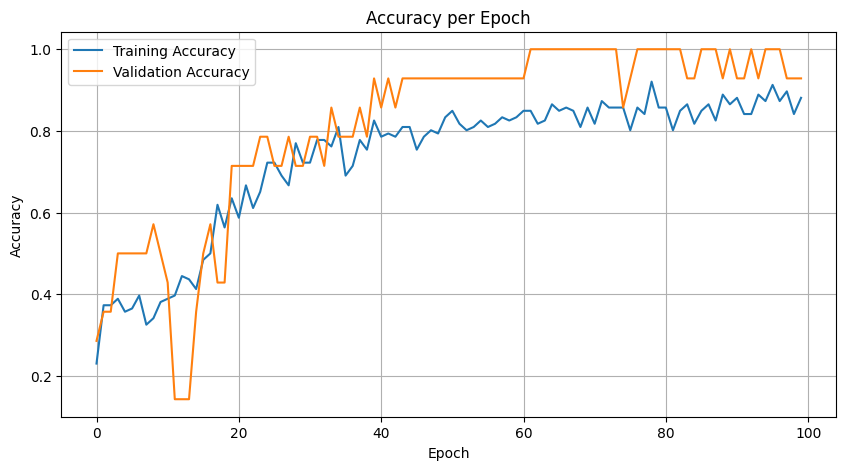

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

inference Model

In [33]:
def prediksi_kondisi_keuangan(data_baru: pd.DataFrame):
    print(">> Mulai prediksi")

    data_baru['rasio_transaksi'] = data_baru['jumlah_transaksi'] / (data_baru['pengeluaran'] + 1)
    data_baru['persen_pengeluaran'] = data_baru['pengeluaran'] / (data_baru['pemasukan'] + data_baru['pengeluaran'] + 1e-9)

    features = [
        'pemasukan',
        'pengeluaran',
        'jumlah_transaksi',
        'jumlah_hari_rugi',
        'rasio_transaksi',
        'persen_pengeluaran'
    ]
    X_new = data_baru[features]
    X_new_scaled = scaler.transform(X_new)

    print(">> Transformasi selesai, mulai prediksi")
    y_probs = model.predict(X_new)
    print(">> Probabilitas:", y_probs)

    y_pred_class = np.argmax(y_probs, axis=1)
    label_pred = le.inverse_transform(y_pred_class)

    print(">> Hasil kelas:", label_pred)
    return label_pred[0]


In [34]:
# Contoh data baru yang ingin diprediksi
data_baru = pd.DataFrame([{
    'pemasukan': 3000000,
    'pengeluaran': 2950000,
    'jumlah_transaksi': 12,
    'jumlah_hari_rugi': 6
}])

# Panggil fungsi prediksi dan tampilkan hasil
hasil = prediksi_kondisi_keuangan(data_baru)
print("Prediksi kondisi keuangan:", hasil)


>> Mulai prediksi
>> Transformasi selesai, mulai prediksi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>> Probabilitas: [[1. 0. 0. 0.]]
>> Hasil kelas: ['Cukup Sehat']
Prediksi kondisi keuangan: Cukup Sehat
